**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 03. LangGraph 입문 프로젝트

    - **📒[실습]** Clip 04. Structured Output - 원하는 형태로 논문 정보 반환하기

## 원하는 형태로 출력하는 방법 ([Structured Output](https://python.langchain.com/docs/how_to/structured_output/))

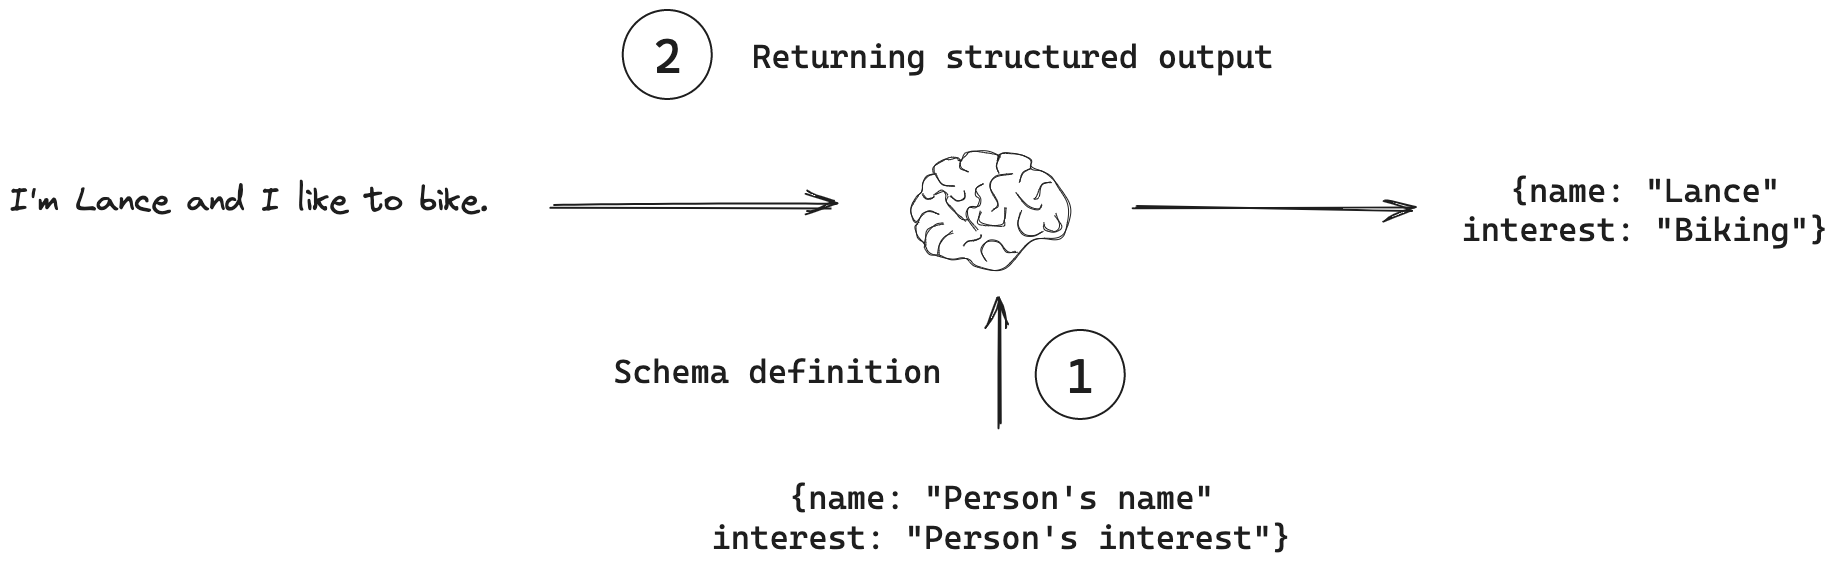

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [2]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


class MovieResponse(BaseModel):
    """Respond to the user with this"""
    
    title: str = Field(description="영화 제목")
    director: str = Field(description="감독 이름")
    genre: str = Field(description="장르")
    release_year: int = Field(description="개봉 연도")

In [3]:
model = ChatOpenAI(model="gpt-4o")
model_with_structured_output = model.with_structured_output(MovieResponse)

In [4]:
model_with_structured_output.invoke("타이타닉 영화에 대해 설명해주세요.")

MovieResponse(title='타이타닉 (Titanic)', director='제임스 카메론 (James Cameron)', genre='로맨스, 드라마', release_year=1997)

- 여러개의 스키마 지정하는 방법

In [5]:
from typing import Union

class MovieResponse(BaseModel):
    """Respond to the user with this"""
    
    title: str = Field(description="영화 제목")
    director: str = Field(description="감독 이름")
    genre: str = Field(description="장르")
    release_year: int = Field(description="개봉 연도")

class ConversationalResponse(BaseModel):
    """Respond in a conversational manner. Be kind and helpful."""

    response: str = Field(description="A conversational response to the user's query")


class FinalResponse(BaseModel):
    final_output: Union[MovieResponse, ConversationalResponse]


structured_llm = model.with_structured_output(FinalResponse)

In [6]:
structured_llm.invoke("타이타닉에 대해 알려주세요.")

FinalResponse(final_output=MovieResponse(title='타이타닉', director='제임스 카메론', genre='로맨스, 드라마', release_year=1997))

In [7]:
structured_llm.invoke("오늘 기분 어때?")

FinalResponse(final_output=ConversationalResponse(response='안녕하세요! 만나게 되어 반가워요. 저는 항상 긍정적이고 여러분의 질문에 답을 드리려고 노력하고 있어요. 😊 오늘 하루 어떠셨나요? 기분 좋은 하루 보내셨길 바라요!'))

## Structured Output 의 출력을 하는 LangGraph Agent

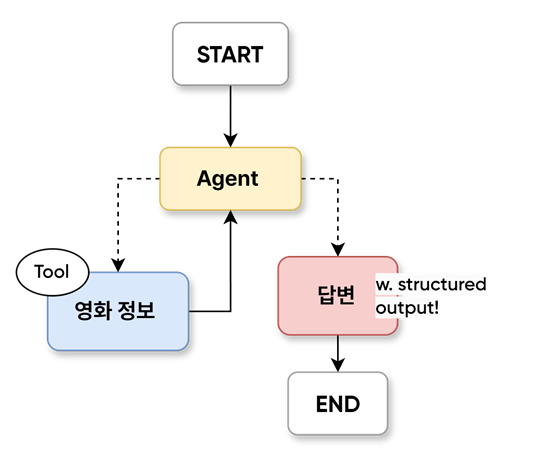

### Step 1. 출력을 위한 데이터 클래스 지정하기

In [8]:
class MovieResponse(BaseModel):
    """Respond to the user with this"""
    
    title: str = Field(description="영화 제목")
    director: str = Field(description="감독 이름")
    genre: str = Field(description="장르")
    release_year: int = Field(description="개봉 연도")

### Step 2. Graph State 설정하기

- MessagesState : `"messages"` key를 상속하여 채팅 메시지를 관리하는 State

In [9]:
from langgraph.graph import MessagesState


class State(MessagesState):
    final_response: MovieResponse

### Step 3. 영화 정보를 주는 Tool(도구)와 노드 설정하기

In [10]:
from typing import Literal
from langchain_core.tools import tool

@tool
def get_movieinfo(movie: Literal["타이타닉", "노팅힐"]):
    """Use this to get movie information."""
    if movie == "타이타닉":
        return "영화 타이타닉은 1997년 개봉하였고, 감독은 제임스 카메론입니다. 장르는 로맨스/드라마입니다."
    elif movie == "노팅힐":
        return "영화 노팅힐은 1999년 개봉하였고, 감독은 로저 미첼입니다. 장르는 로맨틱 코미디입니다."
    else:
        raise AssertionError("Unknown movie")

In [11]:
tools = [get_movieinfo]

model_with_tool = model.bind_tools(tools)

In [12]:
def call_model(state: State):
    response = model_with_tool.invoke(state["messages"]) # tool_calls or 일반적인
    return {"messages": [response]}

### Step 4. 답변 노드 추가하기

In [13]:
from langchain_core.messages import HumanMessage

model = ChatOpenAI(model="gpt-4o")
model_with_structured_output = model.with_structured_output(MovieResponse)

def respond(state: State):
    response = model_with_structured_output.invoke(
        [HumanMessage(content=state["messages"][-2].content)] # [-2]: ToolMessage [-1]: AIMessage
    )

    return {"final_response": response}

In [14]:
def should_continue(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "respond"
    else:
        return "continue"

### Step 5. Graph 생성하기

In [15]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(State)

graph_builder.add_node("agent", call_model)
graph_builder.add_node("respond", respond)
graph_builder.add_node("tools", ToolNode(tools))

- `ToolNode` : 마지막 AIMessage에서 호출된 도구를 실행하는 노드

In [16]:
graph_builder.set_entry_point("agent")

graph_builder.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("respond", END)
graph = graph_builder.compile()

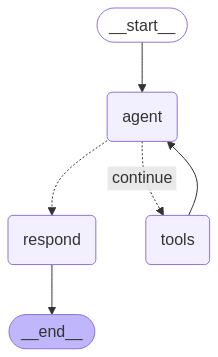

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
answer = graph.invoke(input={"messages": [("human", "타이타닉 영화에 대해 알려주세요.")]})[
    "final_response"
]
print(answer)

title='타이타닉' director='제임스 카메론' genre='로맨스/드라마' release_year=1997


In [19]:
answer = graph.invoke(input={"messages": [("human", "영화 노팅힐의 정보를 알려줘.")]})[
    "final_response"
]
print(answer)

title='노팅힐' director='로저 미첼' genre='로맨틱 코미디' release_year=1999


In [20]:
graph.invoke(input={"messages": [("human", "영화 노팅힐의 정보를 알려줘.")]})

{'messages': [HumanMessage(content='영화 노팅힐의 정보를 알려줘.', additional_kwargs={}, response_metadata={}, id='b287d606-0545-4638-a4a1-6de80d854b91'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7NuC1XLzp2MnYuUlhuIYXMgU', 'function': {'arguments': '{"movie":"노팅힐"}', 'name': 'get_movieinfo'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 68, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6b6e24b474', 'id': 'chatcmpl-BP2MMN50DD0BPbmoqQRY2qJWw0ZrY', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a5cdbec0-04e0-4cc2-b30d-9bdea65de125-0', tool_calls=[{'name': 'get_movieinfo', 'args': {'movie': '노팅힐'}, 'id': 'call_7NuC1XLzp2MnYuUlhuIYXMgU', 'type': 'tool_cal

## 논문 정보를 반환하는 [ArXiv Tool](https://python.langchain.com/docs/integrations/tools/arxiv/) 사용하기

`pip install arxiv`

In [21]:
from langchain_community.utilities import ArxivAPIWrapper

In [22]:
arxiv = ArxivAPIWrapper()
docs = arxiv.run("1605.08386")

In [23]:
print(docs)

Published: 2016-05-26
Title: Heat-bath random walks with Markov bases
Authors: Caprice Stanley, Tobias Windisch
Summary: Graphs on lattice points are studied whose edges come from a finite set of
allowed moves of arbitrary length. We show that the diameter of these graphs on
fibers of a fixed integer matrix can be bounded from above by a constant. We
then study the mixing behaviour of heat-bath random walks on these graphs. We
also state explicit conditions on the set of moves so that the heat-bath random
walk, a generalization of the Glauber dynamics, is an expander in fixed
dimension.


In [24]:
docs = arxiv.run("2312.15166")
print(docs)

Published: 2024-04-04
Title: SOLAR 10.7B: Scaling Large Language Models with Simple yet Effective Depth Up-Scaling
Authors: Dahyun Kim, Chanjun Park, Sanghoon Kim, Wonsung Lee, Wonho Song, Yunsu Kim, Hyeonwoo Kim, Yungi Kim, Hyeonju Lee, Jihoo Kim, Changbae Ahn, Seonghoon Yang, Sukyung Lee, Hyunbyung Park, Gyoungjin Gim, Mikyoung Cha, Hwalsuk Lee, Sunghun Kim
Summary: We introduce SOLAR 10.7B, a large language model (LLM) with 10.7 billion
parameters, demonstrating superior performance in various natural language
processing (NLP) tasks. Inspired by recent efforts to efficiently up-scale
LLMs, we present a method for scaling LLMs called depth up-scaling (DUS), which
encompasses depthwise scaling and continued pretraining. In contrast to other
LLM up-scaling methods that use mixture-of-experts, DUS does not require
complex changes to train and inference efficiently. We show experimentally that
DUS is simple yet effective in scaling up high-performance LLMs from small
ones. Building on th

In [25]:
type(docs)

str

In [26]:
docs = arxiv.run("1605.08386WWW")
print(docs)

No good Arxiv Result was found


## 사용자 지정 출력 형태에 맞춰 논문 정보 반환하는 Agent

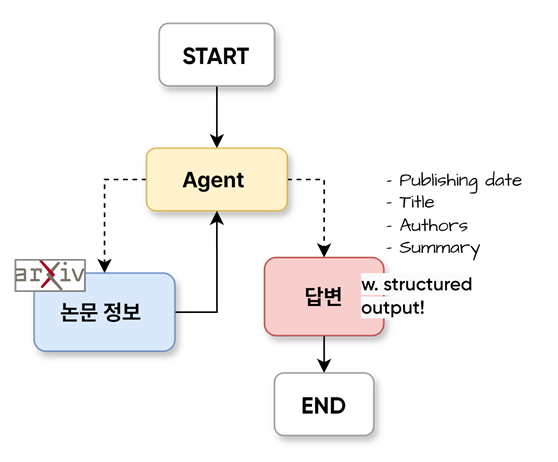

- Publishing date
- Title
- Authors
- Summary

### Step 1. 출력을 위한 데이터 클래스 지정하기

In [27]:
from pydantic import BaseModel, Field


class PaperResponse(BaseModel):
    """Respond to the user with this"""

    published: str = Field(description="The date the paper was published")
    title: str = Field(description="The title of the paper")
    authors: list[str] = Field(description="The Authors who wrote the paper")
    summary: str = Field(description="The summary of the paper")

In [28]:
from langgraph.graph import MessagesState

class State(MessagesState):
    final_response: PaperResponse

### Step 2. 논문 정보를 호출하고 답변하는 Node 추가하기

In [29]:
from langchain_core.tools import tool

@tool
def get_paper(arxivId: str):
    """Use this to get paper information."""
    
    paper = arxiv.run(arxivId)
    return paper

In [30]:
tools = [get_paper]

model_with_tool = model.bind_tools(tools)

In [31]:
def call_model(state: State):
    response = model_with_tool.invoke(state["messages"])
    return {"messages": [response]}

In [32]:
from langchain_core.messages import HumanMessage

model = ChatOpenAI(model="gpt-4o")
model_with_structured_output = model.with_structured_output(PaperResponse)

def respond(state: State):
    response = model_with_structured_output.invoke(
        [HumanMessage(content=state["messages"][-2].content)] # [-2]: ToolMessage [-1]: AIMessage
    )

    return {"final_response": response}

### Step 3. Graph 생성하기

In [33]:
def should_continue(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "respond"
    else:
        return "continue"

In [34]:
graph_builder = StateGraph(State)

graph_builder.add_node("agent", call_model)
graph_builder.add_node("respond", respond)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.set_entry_point("agent")

graph_builder.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("respond", END)
graph = graph_builder.compile()

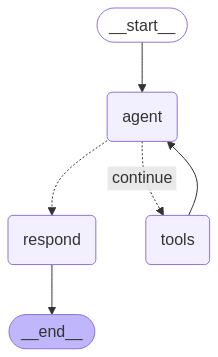

In [79]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
answer = graph.invoke(input={"messages": [("human", "2312.15166 논문에 대해 알려줘.")]})[
    "final_response"
]

In [36]:
answer

PaperResponse(published='2024-04-04', title='SOLAR 10.7B: Scaling Large Language Models with Simple yet Effective Depth Up-Scaling', authors=['Dahyun Kim', 'Chanjun Park', 'Sanghoon Kim', 'Wonsung Lee', 'Wonho Song', 'Yunsu Kim', 'Hyeonwoo Kim', 'Yungi Kim', 'Hyeonju Lee', 'Jihoo Kim', 'Changbae Ahn', 'Seonghoon Yang', 'Sukyung Lee', 'Hyunbyung Park', 'Gyoungjin Gim', 'Mikyoung Cha', 'Hwalsuk Lee', 'Sunghun Kim'], summary='We introduce SOLAR 10.7B, a large language model (LLM) with 10.7 billion parameters, demonstrating superior performance in various natural language processing (NLP) tasks. Inspired by recent efforts to efficiently up-scale LLMs, we present a method for scaling LLMs called depth up-scaling (DUS), which encompasses depthwise scaling and continued pretraining. In contrast to other LLM up-scaling methods that use mixture-of-experts, DUS does not require complex changes to train and inference efficiently. We show experimentally that DUS is simple yet effective in scaling 

In [37]:
print(answer.published)

2024-04-04


In [38]:
print(answer.title)

SOLAR 10.7B: Scaling Large Language Models with Simple yet Effective Depth Up-Scaling
